# 프로젝트: 뉴스기사 요약해보기

## 데이터 수집하기

In [1]:
# 라이브러리 로드
# 패키지 다운로드
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/ssac26/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* 뉴스기사데이터 다운로드

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
15984,Australia hire 3 Indian spin specialists ahead...,Australian cricket team has hired three Indian...
14934,SoftBank's Masayoshi Son offers free solar pow...,Japanese conglomerate SoftBank's Chairman Masa...
42272,MP CM Shivraj holds meeting in candlelight dur...,"On the occasion of Earth Hour on Saturday, Mad..."
27483,US losing patience: Trump warns NATO over defe...,Warning NATO allies that the US is losing pati...
40565,I am not shy to go nude onscreen: Ranbir Kapoor,"Ranbir Kapoor, who has done a nude scene for S..."
40132,Play dirty to get int'l permit: AirAsia CEO in...,In a purported audio-clip of AirAsia CEO Tony ...
72165,Govt waives fee on late GST returns for July,The government waived off late filing fee for ...
8982,Gambling firm's billionaire founder pays herse...,"Denise Coates, the billionaire founder and co-..."
68780,Karni Sena members burn Padmavati posters in J...,"According to reports, the members of Rajput or..."
8991,"Delhi govt to hold special session, discuss Ke...",Delhi Deputy CM Manish Sisodia on Thursday ann...


* headlines, text로 구성
* 추상적요약시 text에 따른 headlines바탕으로 학습
* 추출적요약시 text만 사용

## 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

* 중복데이터 처리

In [4]:
print(data['headlines'].nunique())
print(data['text'].nunique())

98280
98360


In [5]:
# 중복 제거
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [6]:
# null값 남아있나 확인
print(data.isnull().sum())
# null있으면 dropna()사용

headlines    0
text         0
dtype: int64


* 텍스트 정규화와 불용어 제거

In [7]:
# 노드에서 사용한 정규화 사전 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [8]:
# NLTK에서 제공 불용어 리스트로, 샘플에서 불용어를 제거
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거? -1
    # ??
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
# preprocess_sentence(temp_summary, False)  # 불용어를 제거하지 않습니다.

In [11]:
# 텍스트데이터에 전처리 수행
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
# headlines 전처리, 불용어 처리 
clean_summary = []


for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
# 보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장.빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체
data['text'] = clean_text
data['headlines'] = clean_summary


# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [14]:
len(data)

98360

In [15]:
# #  빈샘플 있을경우 제거
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :',(len(data)))

* train/test나누기 ( 샘플최대길이 확인필요)

1 60 35.09968483123221
1 16 9.299532330215534


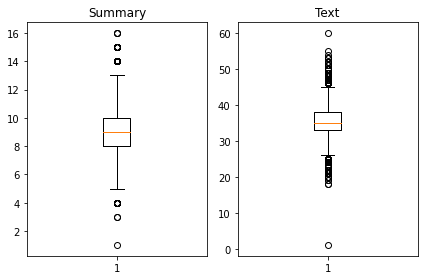

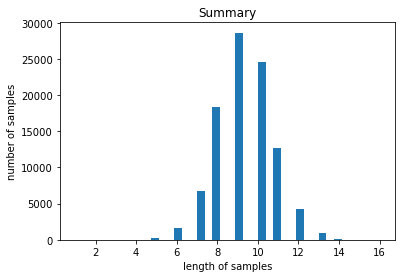

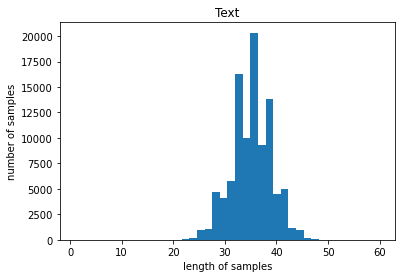

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt
#띄어쓰기기준으로 분리해서 리스트화
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print(np.min(text_len),np.max(text_len),np.mean(text_len))
print(np.min(summary_len), np.max(summary_len),np.mean(summary_len))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
# 평균 근처로 임의 설정 - 절반이므로 다른수치로
text_max_len = 38
summary_max_len = 10

In [18]:
# 노드 참고

In [19]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [21]:
# 약20% 정도의 내용손실 예상
# 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

In [22]:
#요약 데이터에 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [23]:
#  인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
# 분리패키지, 직접 분리 중 직접분리 사용
#  encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스
# np.arange(A) A범위만큼 array생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[56971 84984 58312 ... 14382 22067 96199]


In [25]:
indices.shape

(98360,)

In [26]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플이 나옴
#
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [27]:
# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19672


In [28]:
# 전체 텍스트데이터 갯수 이용해 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))


훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


* 정수 인코딩

In [29]:
src_tokenizer = Tokenizer() 
src_tokenizer.fit_on_texts(encoder_input_train)
# 생성된 단어 집합은 src_tokenizer.word_index에 저장

In [30]:
# 등장 빈도수가  미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
# src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69590
등장 빈도가 5번 이하인 희귀 단어의 수: 45598
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23992
단어 집합에서 희귀 단어의 비율: 65.52378215260813
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0872064198770217


In [31]:
# 등장횟수 5이하인 희귀단어가 전체문장중 등장비율은 3프로이므로 제외해도 괜찮을거 같다,

In [32]:
# 단어집합크기 제한
src_vocab = 22000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [33]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[210, 480, 133, 841, 451, 899, 1160, 802, 2479, 195, 98, 1818, 310, 8420, 449, 4259, 712, 3206, 1247, 2479, 802, 5344, 133, 142, 43, 464, 635, 143, 451, 1810, 934, 355, 1244], [636, 20705, 322, 133, 170, 1202, 205, 147, 1556, 1824, 1, 14827, 3715, 3738, 20705, 643, 53, 436, 7789, 2354, 1411, 8147, 3759, 391, 279, 12212, 39, 5650, 19425, 472, 4, 20705], [2679, 368, 193, 7067, 829, 301, 7, 11, 2304, 724, 266, 41, 270, 2, 836, 7, 41, 194, 73, 433, 757, 86, 193, 383, 73, 604, 1642, 2583, 1326, 301, 194, 11, 724, 73, 266, 99]]


* headlines도 동일작업

In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 
# 이는 tar_tokenizer.word_index에 저장되어있어요.
# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데,, 
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 30019
등장 빈도가 5번 이하인 희귀 단어의 수: 19603
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10416
단어 집합에서 희귀 단어의 비율: 65.30197541557014
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.638343723733435


In [36]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 164, 1401, 579, 87, 2397, 1264, 4272], [1, 50, 122, 31, 10, 8201, 375, 1442, 129, 7, 754], [1, 93, 1124, 1368, 16, 9, 336, 51, 12], [1, 1337, 3325, 1531, 39, 15, 396, 3911, 2518], [1, 346, 900, 3597, 1280, 87, 9565]]
target
decoder  [[164, 1401, 579, 87, 2397, 1264, 4272, 2], [50, 122, 31, 10, 8201, 375, 1442, 129, 7, 754, 2], [93, 1124, 1368, 16, 9, 336, 51, 12, 2], [1337, 3325, 1531, 39, 15, 396, 3911, 2518, 2], [346, 900, 3597, 1280, 87, 9565, 2]]


* 변환결과 길이가 0이 된 문장 확인

In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

# 변환결과 길이 0이된 문장은 없다.

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


* 패딩하기

In [38]:
# post방식으로 패딩 (뒷부분을 0으로)
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

# 전 처 리 완 료

## 모델 설계하기

* 인코더

In [39]:
# 노드에서 사용한 함수형 인코더
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

* 디코더

In [40]:
# 기본 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

* 어텐션함수를 디코더의 출력층에 결합

In [41]:
# # 어텐션 메커니즘 적용한 디코더
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [42]:
## 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고,
## 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태

## 모델 훈련하기

In [43]:
## 노드 모델 참고 (\는?)
## early stopping사용
## 동일로스 5회 관측시 스탑

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 103s 333ms/step - loss: 6.3642 - val_loss: 5.9515
Epoch 2/50
308/308 [==============================] - 98s 318ms/step - loss: 5.7797 - val_loss: 5.4994
Epoch 3/50
308/308 [==============================] - 98s 318ms/step - loss: 5.3755 - val_loss: 5.2008
Epoch 4/50
308/308 [==============================] - 98s 319ms/step - loss: 5.0841 - val_loss: 5.0035
Epoch 5/50
308/308 [==============================] - 98s 318ms/step - loss: 4.8478 - val_loss: 4.8261
Epoch 6/50
308/308 [==============================] - 98s 319ms/step - loss: 4.6472 - val_loss: 4.6755
Epoch 7/50
308/308 [==============================] - 99s 320ms/step - loss: 4.4715 - val_loss: 4.5644
Epoch 8/50
308/308 [==============================] - 98s 319ms/step - loss: 4.3188 - val_loss: 4.4675
Epoch 9/50
308/308 [==============================] - 98s 319ms/step - loss: 4.1878 - val_loss: 4.3898
Epoch 10/50
308/308 [==============================] - 98s 318ms/step - 

* 훈련과정 시각화

In [46]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

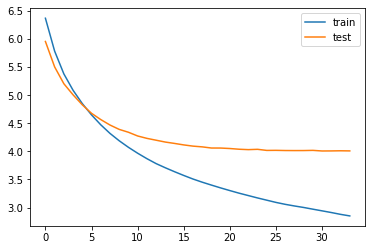

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 실제결과와 요약문 비교

In [ ]:
### 인퍼런스모델 구현 ??

* 테스트

* 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원필요
* seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행


In [49]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비

정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계 별도. 이때는 인코더 모델과 디코더 모델을 분리해서 설계필요

In [50]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [51]:
# 어텐션 메커니즘 사용 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [52]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [53]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
# 패딩을 위해 사용되는 숫자 0을 제외
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [55]:
# 50개 샘플에 대해 실제결과와 비교
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : sunny deol revealed child problems reading writing added iq reflex good though class great student used score pass marks rather good sports co activities added sunny later went film school london 
실제 요약 : as child had problem in reading and writing sunny deol 
예측 요약 :  was not proud of my father sunny deol


원문 : former rbi governor raghuram rajan said always better promise achieve notion say best nobody else like us well true said stating india capable rajan said let us confident let us achieved 
실제 요약 : better to under promise and over achieve raghuram rajan 
예측 요약 :  cannot be very good like like bad rajan


원문 : southwest airlines austin chicago flight diverted back austin airport tuesday brawl two passengers mid air fight reportedly erupted one passengers intoxicated punched fellow flyer security escorted passengers flight delayed several hours 
실제 요약 : flight diverted after drunk flyer punches another 
예측 요약 :  flight makes emergency landing after flyer tries off plane


원문 

* 2개의 컬럼을 가진 DF에 실제요약과 예측요약을 넣고 비교하려 했으나 실패해서 구글로 수동작업함

In [ ]:
# 1번 : 연구자의 연구결과, 실제요약 - 마지막부분제외하곤 비슷함, 테스트결과 - 잘못됨
# 2번 : RBI총재의 약속, 둘다 틀림
# 3번 : 폭력으로 인한 비행지연, 실제요약 - 비행우회, 테스트 - 이륙후 비상착륙 >>단어선택 약간 잘못된거 빼곤 잘 요약
# 4번 : 톰홀랜드 타이틀 공개, 예측요약 실패
# 5번 : 유명인이 병원방문해서 체스, 테스트 -마지막부분 단어선택실패
# 6번 : 추문으로 인해 사임 테스트 - 요점을 잘 집어냄 (XX, 성희롱조사)

## 절반정도의 예측정확도, 마지막 단어선택의 잘못 문제 발생

## summa 이용해서 추출적 요약해보기

In [83]:
#pip install summa
import requests
from summa.summarizer import summarize
result2 = data.text[:10]
result2


0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
5    pakistani singer rahat fateh ali khan denied r...
6    india recorded lowest odi total new zealand ge...
7    weeks ex cbi director alok verma told departme...
8    andhra pradesh cm chandrababu naidu said met u...
9    congress candidate shafia zubair ramgarh assem...
Name: text, dtype: object

In [97]:
type(result2[1])

str

In [98]:
summarize(result2[1], ratio=0.3, words=8)

''

In [ ]:
# summarize의 입력으로 str을 넣었는데도 결과가 안나옴